In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cloudpickle as pickle
### Pytorch
import torch
import torch.nn as nn
from fastai.tabular import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, average_precision_score, f1_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
GLOBAL_SEED = 20210117
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(GLOBAL_SEED) 

# 1. Import data

In [3]:
[data_raw, protein_raw, activities_raw, 
 data_extend, protein_extend, activities_extend] = pickle.load(open('NR.pkl', 'rb'))
#mean, std = data_raw.mean(), data_raw.std() 

In [4]:
cont_names = data_raw.columns
cat_names = []
dep_var = 'Activity'
data_raw['Activity'] = [int(i<1) for i in activities_raw]
data_extend['Activity'] = [int(i<1) for i in activities_extend]
data_raw.shape, data_extend.shape
list(data_raw['Activity']).count(0), list(data_raw['Activity']).count(1)

((6554, 218), (713, 218))

(3129, 3425)

# 2. Create descriptor sets (only protein / only ligand / protein+ligand)

In [5]:
def oversampling(data, N=3000, sigma=0.1, test_size=0.4):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    protein_train = np.array([i.split('_')[0] for i in data.index])
    for train_idx, valid_idx in sss.split(data, protein_train):pass
    # sampling
    sample_data = []
    sample_label = []
    sample_proteins = []
    train_temp = data.iloc[train_idx, :]
    proteins = np.array([i.split('_')[0] for i in train_temp.index])
    for p in set(proteins):
        temp = train_temp.loc[proteins==p, :]
        if N-sum(proteins==p)<=0:
            continue
        for _ in range(N-sum(proteins==p)):
            rrow = list(temp.iloc[random.choice(range(len(temp.index))), :])
            sample_data.append(rrow)
            sample_label.append(int(rrow[-1]))
            sample_proteins.append(p)
    if len(sample_label) == 0:
        return data, train_idx, valid_idx
    sample_data = pd.DataFrame(norm.rvs(np.array(sample_data), scale=sigma), columns=data.columns)
    sample_data.index = [sample_proteins[i]+'_OS_'+str(i) for i in range(len(sample_proteins))]
    sample_data[dep_var] = sample_label
    os_data = pd.DataFrame(data)
    os_data = os_data.append(sample_data)
    os_train_idx = list(set(range(len(os_data.index)))-set(valid_idx))
    return os_data, os_train_idx, valid_idx

In [6]:
N, train_size, test_aucs, extend_aucs, result = pickle.load(open('NR_surface_RF_n501_f0.1_dNone.pkl', 'rb'))

In [7]:
result.sort_values(['Extend AUC']).tail()

,N,Train size,Tets AUC,Extend AUC
65,4500,0.80,0.907805,0.779927
37,3000,0.85,0.904901,0.780862
74,5000,0.80,0.908622,0.781009
54,4000,0.90,0.904789,0.782977
73,5000,0.85,0.904486,0.785666


# 3. Predition and evaluation

In [8]:
N = 5000
tr = 0.85
n_estimators = 501; max_features=0.1; max_depth=None

os_data, train_idx, valid_idx = oversampling(data_raw, N, sigma=0.1, test_size=1-tr)
train_data = os_data.iloc[train_idx, :]
valid_data = os_data.iloc[valid_idx, :]
clf = RandomForestClassifier(n_estimators = n_estimators, max_features=max_features, max_depth=max_depth)
_ = clf.fit(train_data.loc[:, cont_names], train_data.loc[:, dep_var])

### Evaluate Valid
pre_pro = clf.predict_proba(valid_data.loc[:, cont_names])
pre_pro = [i[0] for i in pre_pro]
pred = 1-clf.predict(valid_data.loc[:, cont_names])
fpr1, tpr1, thresholds1 = roc_curve(np.array(valid_data[dep_var]), pre_pro)
valid_auc = roc_auc_score(valid_data.loc[:, dep_var], pre_pro)
acc = accuracy_score(valid_data.loc[:, dep_var], pred)
precision = precision_score(valid_data.loc[:, dep_var], pred)
recall = recall_score(valid_data.loc[:, dep_var], pred)
f1 = f1_score(valid_data.loc[:, dep_var], pred)
np.round([acc, precision, recall, f1, valid_auc], 3)

### Evaluate Extend
pre_pro = clf.predict_proba(data_extend.loc[:, cont_names])
pre_pro = [i[0] for i in pre_pro]
pred = 1-clf.predict(data_extend.loc[:, cont_names])
fpr2, tpr2, thresholds2 = roc_curve(np.array(data_extend[dep_var]), pre_pro)
extend_auc = roc_auc_score(data_extend.loc[:, dep_var], pre_pro)
acc = accuracy_score(data_extend.loc[:, dep_var], pred)
precision = precision_score(data_extend.loc[:, dep_var], pred)
recall = recall_score(data_extend.loc[:, dep_var], pred)
f1 = f1_score(data_extend.loc[:, dep_var], pred)
np.round([acc, precision, recall, f1, extend_auc], 3)

array([0.165, 0.167, 0.176, 0.171, 0.096])

array([0.278, 0.244, 0.386, 0.299, 0.222])

In [10]:
### Evaluate Valid
pre_pro = clf.predict_proba(valid_data.loc[:, cont_names])
pre_pro = [i[0] for i in pre_pro]
pred = 1-clf.predict(valid_data.loc[:, cont_names])
fpr1, tpr1, thresholds1 = roc_curve(1-np.array(valid_data[dep_var]), pre_pro)
valid_auc = roc_auc_score(1-valid_data.loc[:, dep_var], pre_pro)
acc = accuracy_score(1-valid_data.loc[:, dep_var], pred)
precision = precision_score(1-valid_data.loc[:, dep_var], pred)
recall = recall_score(1-valid_data.loc[:, dep_var], pred)
f1 = f1_score(1-valid_data.loc[:, dep_var], pred)
np.round([acc, precision, recall, f1, valid_auc], 3)

### Evaluate Extend
pre_pro = clf.predict_proba(data_extend.loc[:, cont_names])
pre_pro = [i[0] for i in pre_pro]
pred = 1-clf.predict(data_extend.loc[:, cont_names])
fpr2, tpr2, thresholds2 = roc_curve(1-np.array(data_extend[dep_var]), pre_pro)
extend_auc = roc_auc_score(1-data_extend.loc[:, dep_var], pre_pro)
acc = accuracy_score(1-data_extend.loc[:, dep_var], pred)
precision = precision_score(1-data_extend.loc[:, dep_var], pred)
recall = recall_score(1-data_extend.loc[:, dep_var], pred)
f1 = f1_score(1-data_extend.loc[:, dep_var], pred)
np.round([acc, precision, recall, f1, extend_auc], 3)

array([0.835, 0.833, 0.847, 0.84 , 0.904])

array([0.722, 0.756, 0.794, 0.774, 0.778])

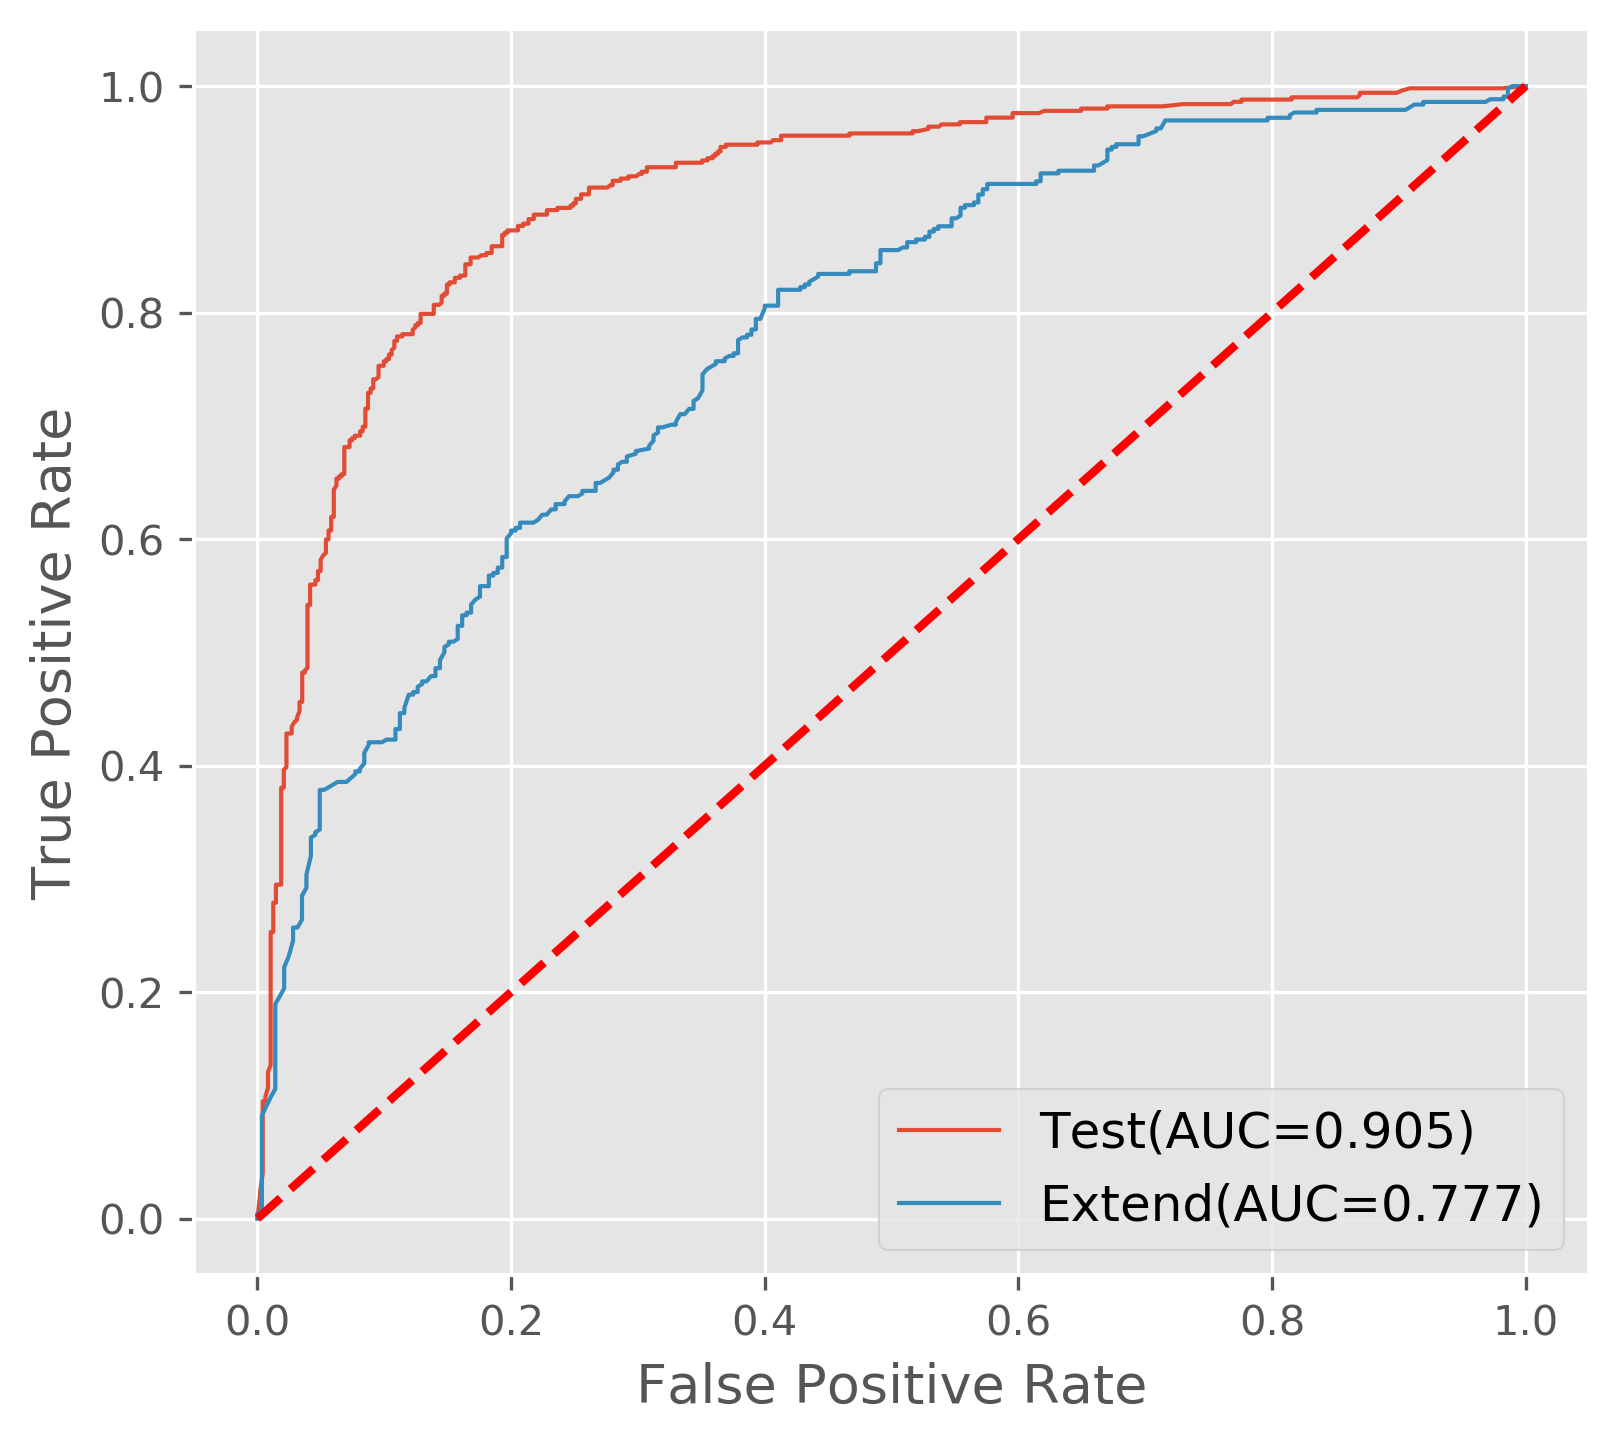

In [10]:
_ = plt.style.use('ggplot')
_ = plt.figure(1, (6, 5.5), dpi=300)
_ = plt.plot(fpr1, tpr1, lw=1, alpha=0.99, label='Test(AUC='+str(round(valid_auc, 3))+')')
_ = plt.plot(fpr2, tpr2, lw=1, alpha=0.99, label='Extend(AUC='+str(round(extend_auc, 3))+')')
_ = plt.plot([0, 1], [0, 1], ls='--', lw=2, color='r')
_ = plt.legend(loc='lower right', fontsize=12)
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('False Positive Rate', fontsize=13)
_ = plt.ylabel('True Positive Rate', fontsize=13)
_ = plt.show()

In [11]:
Protein_Desciptors = [i for i in data_raw.columns[:-1] if 'NR' in i]
Chemical_Desciptors = [i for i in data_raw.columns[:-1] if 'NR' not in i]

valid_data_no_protein = valid_data.copy()
valid_data_no_protein.loc[:, Protein_Desciptors] = 0.0

data_extend_no_protein = data_extend.copy()
data_extend_no_protein.loc[:, Protein_Desciptors] = 0.0

valid_data_no_chemical = valid_data.copy()
valid_data_no_chemical.loc[:, Chemical_Desciptors] = 0.0

data_extend_no_chemical = data_extend.copy()
data_extend_no_chemical.loc[:, Chemical_Desciptors] = 0.0

In [12]:
### Evaluate Valid
pre_pro = clf.predict_proba(valid_data_no_protein.loc[:, cont_names])
pre_pro = [i[0] for i in pre_pro]
pred = 1-clf.predict(valid_data_no_protein.loc[:, cont_names])
fpr1_l, tpr1_l, thresholds1_l = roc_curve(np.array(1-valid_data_no_protein[dep_var]), pre_pro)
valid_auc_l = roc_auc_score(1-valid_data_no_protein.loc[:, dep_var], pre_pro)
acc = accuracy_score(1-valid_data_no_protein.loc[:, dep_var], pred)
precision = precision_score(1-valid_data_no_protein.loc[:, dep_var], pred)
recall = recall_score(1-valid_data_no_protein.loc[:, dep_var], pred)
f1 = f1_score(1-valid_data_no_protein.loc[:, dep_var], pred)
np.round([acc, precision, recall, f1, valid_auc_l], 3)

pre_pro = clf.predict_proba(valid_data_no_chemical.loc[:, cont_names])
pre_pro = [i[0] for i in pre_pro]
pred = 1-clf.predict(valid_data_no_chemical.loc[:, cont_names])
fpr1_p, tpr1_p, thresholds1_p = roc_curve(1-np.array(valid_data_no_chemical[dep_var]), pre_pro)
valid_auc_p = roc_auc_score(1-valid_data_no_chemical.loc[:, dep_var], pre_pro)
acc = accuracy_score(1-valid_data_no_chemical.loc[:, dep_var], pred)
precision = precision_score(1-valid_data_no_chemical.loc[:, dep_var], pred)
recall = recall_score(1-valid_data_no_chemical.loc[:, dep_var], pred)
f1 = f1_score(1-valid_data_no_chemical.loc[:, dep_var], pred)
np.round([acc, precision, recall, f1, valid_auc_p], 3)

### Evaluate Extend
pre_pro = clf.predict_proba(data_extend_no_protein.loc[:, cont_names])
pre_pro = [i[0] for i in pre_pro]
pred = 1-clf.predict(data_extend_no_protein.loc[:, cont_names])
fpr2_l, tpr2_l, thresholds2_l = roc_curve(np.array(1-data_extend_no_protein[dep_var]), pre_pro)
extend_auc_l = roc_auc_score(1-data_extend_no_protein.loc[:, dep_var], pre_pro)
acc = accuracy_score(1-data_extend_no_protein.loc[:, dep_var], pred)
precision = precision_score(1-data_extend_no_protein.loc[:, dep_var], pred)
recall = recall_score(1-data_extend_no_protein.loc[:, dep_var], pred)
f1 = f1_score(1-data_extend_no_protein.loc[:, dep_var], pred)
np.round([acc, precision, recall, f1, extend_auc_l], 3)

pre_pro = clf.predict_proba(data_extend_no_chemical.loc[:, cont_names])
pre_pro = [i[0] for i in pre_pro]
pred = 1-clf.predict(data_extend_no_chemical.loc[:, cont_names])
fpr2_p, tpr2_p, thresholds2_p = roc_curve(1-np.array(data_extend_no_chemical[dep_var]), pre_pro)
extend_auc_p = roc_auc_score(1-data_extend_no_chemical.loc[:, dep_var], pre_pro)
acc = accuracy_score(1-data_extend_no_chemical.loc[:, dep_var], pred)
precision = precision_score(1-data_extend_no_chemical.loc[:, dep_var], pred)
recall = recall_score(1-data_extend_no_chemical.loc[:, dep_var], pred)
f1 = f1_score(1-data_extend_no_chemical.loc[:, dep_var], pred)
np.round([acc, precision, recall, f1, extend_auc_p], 3)

array([0.725, 0.737, 0.715, 0.726, 0.782])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.49 , 0.   , 0.   , 0.   , 0.508])

array([0.694, 0.745, 0.745, 0.745, 0.752])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.4, 0. , 0. , 0. , 0.5])

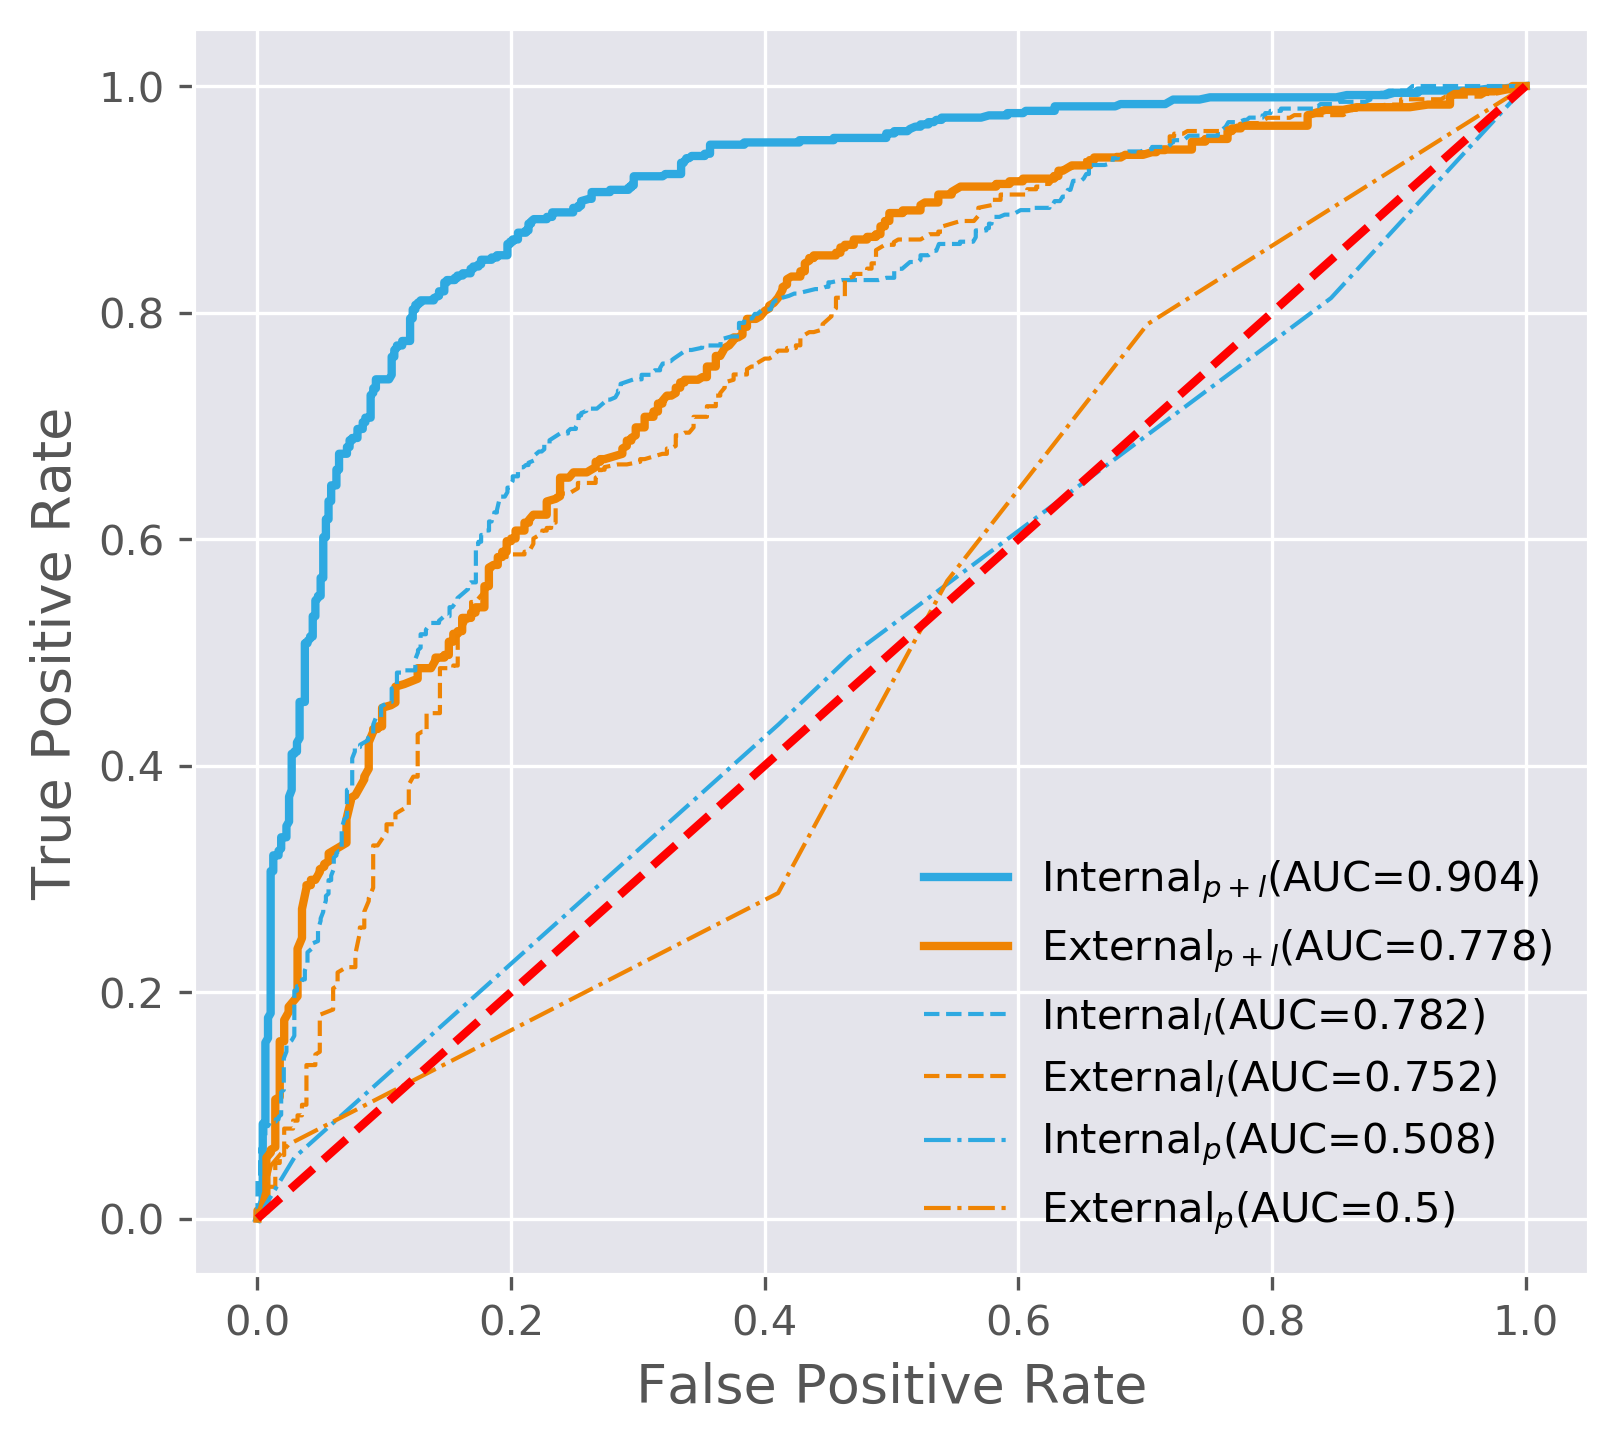

In [13]:
_ = plt.style.use('ggplot')
_ = plt.figure(1, (6, 5.5), dpi=300)
ax = plt.gca(); ax.set_facecolor('#e4e4eb')

_ = plt.plot(fpr1, tpr1, 'b-', lw=2, color='#2ca9e1', alpha=0.99, 
             label='Internal$_{{{}}}$(AUC={})'.format('p+l', round(valid_auc, 3)))
_ = plt.plot(fpr2, tpr2, 'r-', lw=2, color='#f08300', alpha=0.99, 
             label='External$_{{{}}}$(AUC={})'.format('p+l', round(extend_auc, 3)))

_ = plt.plot(fpr1_l, tpr1_l, 'b--', lw=1, color='#2ca9e1', alpha=0.99, 
             label='Internal$_{{{}}}$(AUC={})'.format('l', round(valid_auc_l, 3)))
_ = plt.plot(fpr2_l, tpr2_l, 'r--', lw=1, color='#f08300', alpha=0.99, 
             label='External$_{{{}}}$(AUC={})'.format('l', round(extend_auc_l, 3)))


_ = plt.plot(fpr1_p, tpr1_p, 'b-.', lw=1, color='#2ca9e1', alpha=0.99,
             label='Internal$_{{{}}}$(AUC={})'.format('p', round(valid_auc_p, 3)))
_ = plt.plot(fpr2_p, tpr2_p, 'r-.', lw=1, color='#f08300', alpha=0.99, 
             label='External$_{{{}}}$(AUC={})'.format('p', round(extend_auc_p, 3)))
_ = plt.plot([0, 1], [0, 1], ls='--', lw=2, color='r')
_ = plt.legend(loc='lower right', fontsize=10, frameon=False)
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('False Positive Rate', fontsize=13)
_ = plt.ylabel('True Positive Rate', fontsize=13)
_ = plt.show()

# 4. Correlation between probabilities and real activities

In [15]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [16]:
N = 5000
tr = 0.85
n_estimators = 501; max_features=0.1; max_depth=None

os_data, train_idx, valid_idx = oversampling(data_raw, N, sigma=0.1, test_size=1-tr)
train_data = os_data.iloc[train_idx, :]
valid_data = os_data.iloc[valid_idx, :]
clf = RandomForestClassifier(n_estimators = n_estimators, max_features=max_features, max_depth=max_depth)
_ = clf.fit(train_data.loc[:, cont_names], train_data.loc[:, dep_var])

In [17]:
temp = data_raw.copy()
temp['Activity_value'] = activities_raw
valid_res = temp.loc[valid_data.index, ['Activity', 'Activity_value']]
valid_res['Prob'] = 1-np.array([i[1] for i in clf.predict_proba(valid_data.loc[:, cont_names])])
valid_res.head(2)

temp = data_extend.copy()
temp['Activity_value'] = activities_extend
extend_res = temp.loc[data_extend.index, ['Activity', 'Activity_value']]
extend_res['Prob'] = 1-np.array([i[1] for i in clf.predict_proba(data_extend.loc[:, cont_names])])
extend_res.head(2)

,Activity,Activity_value,Prob
NR1C1_4006,1,10.00,0.107784
NR1C3_8204,0,0.15,0.936128


,Activity,Activity_value,Prob
NR1H4_5857,0,0.0,0.560878
NR1H4_5865,0,0.0,0.578842


In [18]:
valid_res['log_Activity_value'] = np.log(valid_res['Activity_value'])
valid_res = valid_res.replace([np.inf, -np.inf], np.nan)
valid_res = valid_res.dropna(how='any')
r, p = pearsonr(valid_res['log_Activity_value'], valid_res['Prob'])
r, p

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-0.6631615093594151, 1.8990791733388037e-125)

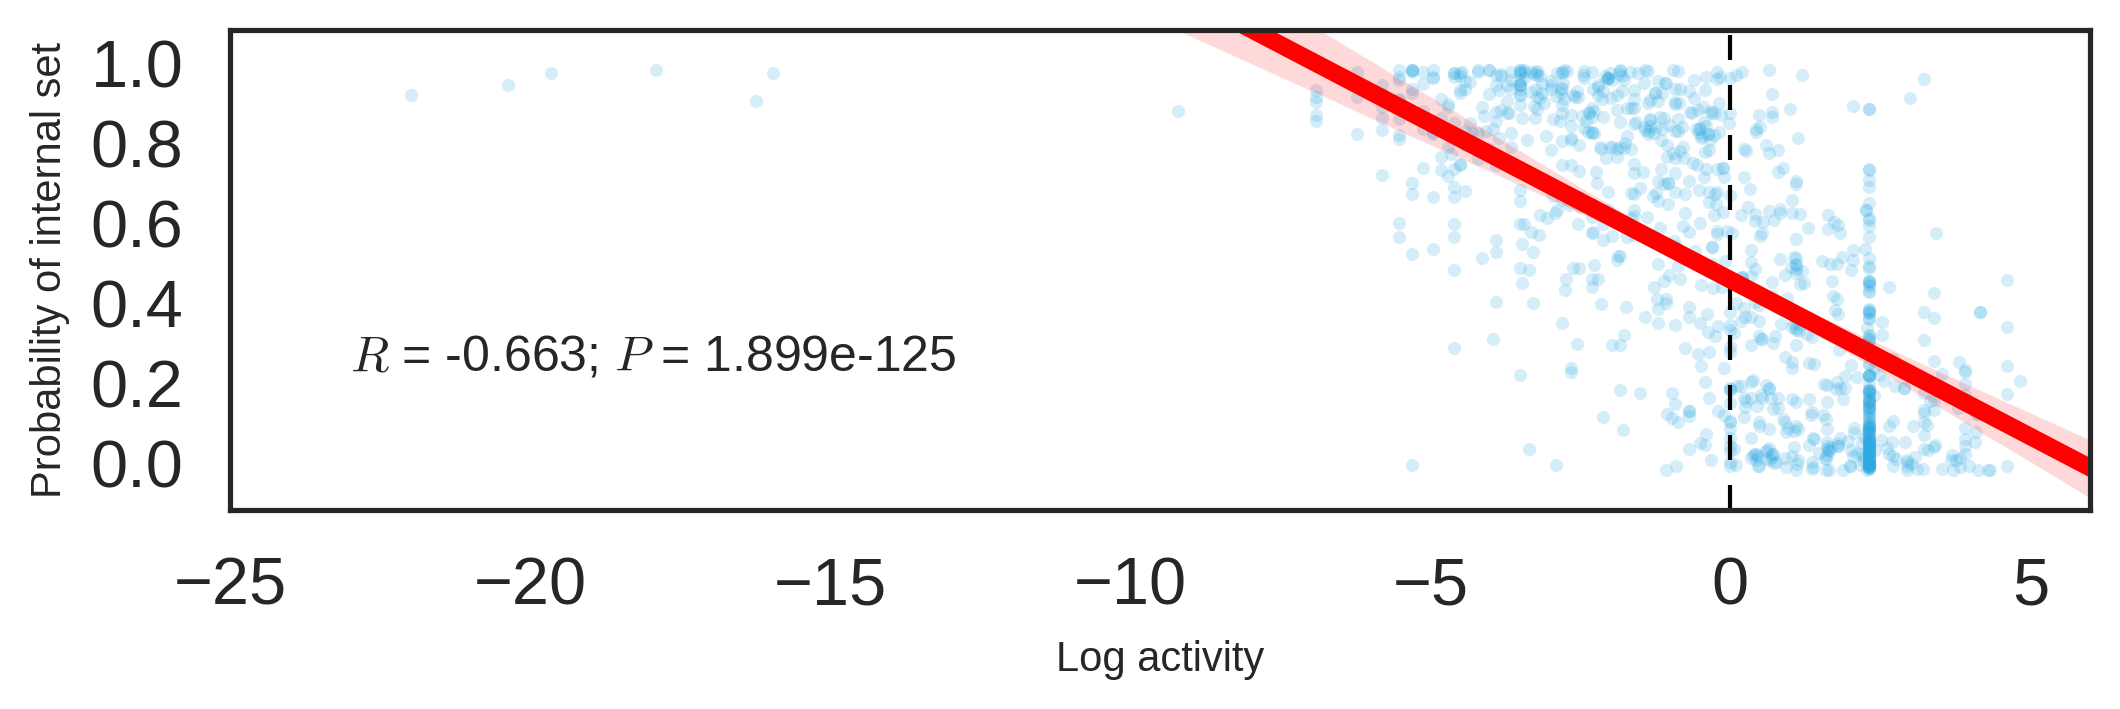

In [40]:
_ = plt.style.use('seaborn-white')
_ = plt.figure(1, (8, 2), dpi=300)
_ = sns.regplot(x="log_Activity_value", y="Prob", data=valid_res, color='r', 
                scatter_kws={'s':10, 'alpha':0.2, 'color':'#2ca9e1'})
_ = plt.vlines(x=0, ymin=-0.1, ymax=1.1, lw=1, ls='--')
_ = plt.annotate('$R$ = -0.663; $P$ = 1.899e-125', (-23, 0.25), fontsize=12)
_ = plt.ylabel('Probability of internal set', fontsize=10)
_ = plt.xlabel('Log activity', fontsize=10)
_ = plt.ylim(-0.1, 1.1)
_ = plt.xlim(-25, 6)

In [20]:
extend_res['log_Activity_value'] = np.log(extend_res['Activity_value'])
extend_res = extend_res.replace([np.inf, -np.inf], np.nan)
extend_res = extend_res.dropna(how='any')
r, p = pearsonr(extend_res['log_Activity_value'], extend_res['Prob'])
r, p

(-0.5194605861282152, 2.5686818172223265e-50)

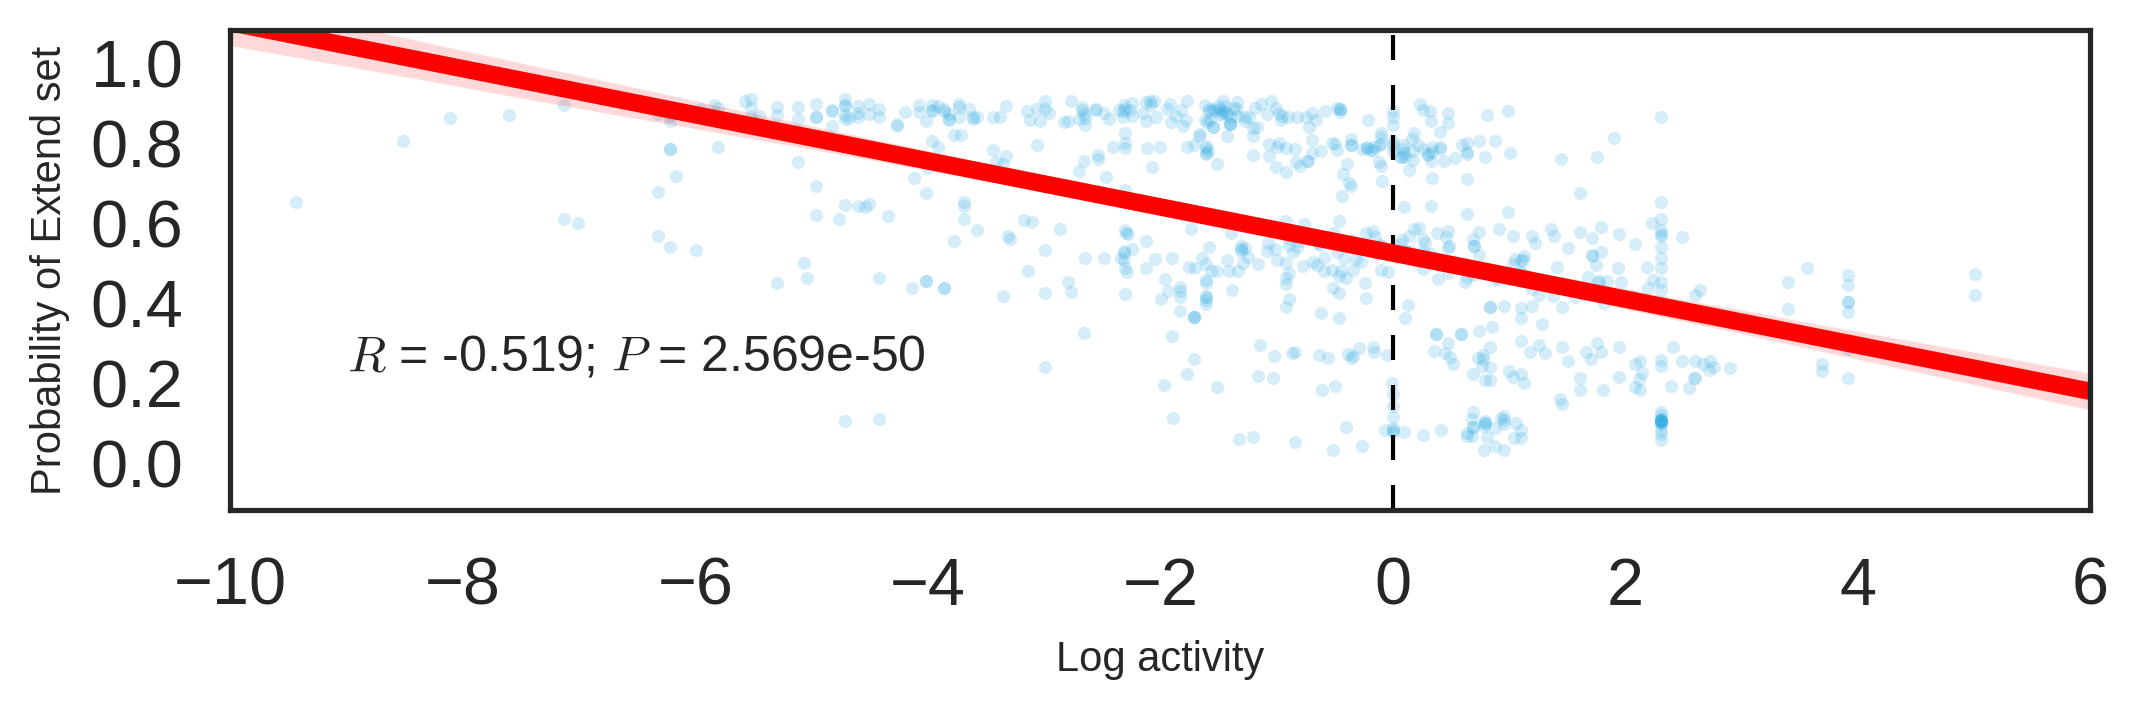

In [41]:
_ = plt.figure(1, (8, 2), dpi=300)
_ = sns.regplot(x="log_Activity_value", y="Prob", data=extend_res, color='r', 
                scatter_kws={'s':10, 'alpha':0.2, 'color':'#2ca9e1'})
_ = plt.vlines(x=0, ymin=-0.1, ymax=1.1, lw=1, ls='--')
_ = plt.annotate('$R$ = -0.519; $P$ = 2.569e-50', (-9, 0.25), fontsize=12)
_ = plt.ylabel('Probability of Extend set', fontsize=10)
_ = plt.xlabel('Log activity', fontsize=10)
_ = plt.ylim(-0.1, 1.1)
_ = plt.xlim(-10, 6)
_ = plt.show()